In [ ]:
import pandas as pd
import numpy as np
import os, json, glob


from collections import defaultdict
from scipy.stats import pearsonr, kendalltau
from sklearn.metrics import cohen_kappa_score
from agreement import cohen_kappa

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from collections import defaultdict
from matplotlib.ticker import MultipleLocator, PercentFormatter
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

# Put at top of plotting script (requires tex be installed though)
matplotlib.rc('font', family='serif')

FULL_WIDTH = 6.75133
COL_WIDTH  = 3.25063


def adjust(fig, left=0.0, right=1.0, bottom=0.0, top=1.0, wspace=0.0, hspace=0.0):
    fig.subplots_adjust(
        left   = left,  # the left side of the subplots of the figure
        right  = right,  # the right side of the subplots of the figure
        bottom = bottom,  # the bottom of the subplots of the figure
        top    = top,  # the top of the subplots of the figure
        wspace = wspace,  # the amount of width reserved for blank space between subplots
        hspace = hspace,  # the amount of height reserved for white space between subplots
    )


def remove_axes(ax):
    ax.spines[['right', 'top']].set_visible(False)

def save_fig(fig, name, dpi=200, base_dir="../paper/images", **kwargs):
    import os
    path = f"{base_dir}/{name}"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    print(f"Image saved in {path}")
    fig.savefig(path, dpi=dpi, bbox_inches='tight', **kwargs)



import json, hashlib


def generate_uuid(content, indent: int = 2) -> str:
    """Deterministic uuid generator of the `content`."""
    content = json.dumps(content, sort_keys=True, indent=indent).encode("utf-8")
    return hashlib.md5(content).hexdigest()


def read_json(fp):
    with open(fp) as f:
        return json.load(f)


COMBINATIONS = (
    2,
#    5
)
MODELS = (
    "gpt-4o-2024-05-13",
    "gpt-3.5-turbo-0125",
    "accounts/fireworks/models/llama-v3p1-70b-instruct",
    "accounts/fireworks/models/qwen2-72b-instruct",
)

PROMPT_TYPES = (
    "subtopic",
    "subtopic_trustworthy",
)

mappings = {"FULL_COVERAGE": 0, "PARTIAL_COVERAGE": 1, "NO_COVERAGE": 2}

## Comparison: GPT-4o-mini vs GPT-4o

In this section, we will compute the Cohen Kappa coefficient between the GPT-4o-mini labels and GPT-4o. This is important, since Laban et al 2024 validate the gpt-4o (non mini version) using manual annotations. To minimize costs, we've replaced that evaluation with a gpt-4o-mini and as a result, would like to assess whether the outputs of these two models are related or if they differ significantly.


### Ref --> Preds
We first assess Cohen's Kappa agreement for the originally proposed `unidirectional` metric.

In [93]:
def get_labels(data1, data2) -> pd.DataFrame:
    results = defaultdict(list)

    union_keys = set(data1).union(set(data2))
    for key in union_keys:
        cover1 = data1.get(key, "NO_COVERAGE")
        cover2 = data2.get(key, "NO_COVERAGE")
    
        results["response_idx"].append(key[0])
        results["ref_uuid"].append(key[1])

        if len(key) == 2:
            results["pred_uuid"].append("NA")
        else:
            results["pred_uuid"].append(key[2])
    
        results["model1_label"].append(cover1)
        results["model2_label"].append(cover2)
    return pd.DataFrame(results)
    


all_results = []
for combination in COMBINATIONS:
    results = []
    for prompt in PROMPT_TYPES:
        for model in MODELS:
            for i in range(1, 6):
                base_dir = "../outputs/run_evals_postprocessing-multi-request"
                gpt4o_data = read_json(f"{base_dir}/gpt-4o-2024-05-13/results_some_shared/{prompt}/SummHay__combinations-{combination}/{model}/topic_news{i}__300__examples0,100.json")
                ref_cvr1 = gpt4o_data["evaluation_assignments"]["metric__bidirectional"]["ref_coverage"]
                ref_cvr1 = {(r["response_idx"], r["ref_uuid"], r["pred_uuid"]): r["coverage"] for r in ref_cvr1}

                gpt4o_mini_data = read_json(f"{base_dir}/gpt-4o-mini-2024-07-18/results_some_shared/{prompt}/SummHay__combinations-{combination}/{model}/topic_news{i}__300__examples0,100.json")
                ref_cvr2 =  gpt4o_mini_data["evaluation_assignments"]["metric__bidirectional"]["ref_coverage"]
                ref_cvr2 = {(r["response_idx"], r["ref_uuid"], r["pred_uuid"]): r["coverage"] for r in ref_cvr2}

                out = get_labels(ref_cvr1, ref_cvr2)
                out["combination"] = combination
                out["prompt"] = prompt
                out["model"] = model
                results.append(out)

    # Report results for each combination number
    results = pd.concat(results)
    print("-" * 40)
    print("Number of documents", combination)
    print("-" * 40)
    print("Number of labels", len(results))
    
    label1, label2 = results["model1_label"].values.tolist(), results["model2_label"].values.tolist()
    
    label1_ints = [mappings[l] for l in label1]
    label2_ints = [mappings[l] for l in label2]
    print("-> Original corr measure (ref -> pred):", np.corrcoef(label1_ints, label2_ints)[0, 1])
    print("-> Pearson correlation (ref -> pred):", pearsonr(label1_ints, label2_ints))
    print("-> KendallTau correlation (ref -> pred):", kendalltau(label1_ints, label2_ints))
    all_results.append(results)


print("\n\n---- Combined ----")
all_results = pd.concat(all_results)
label1, label2 = all_results["model1_label"].values.tolist(), all_results["model2_label"].values.tolist()
print("Cohen Kappa (ref -> pred):",  cohen_kappa(label1, label2))

label1_ints = [mappings[l] for l in label1]
label2_ints = [mappings[l] for l in label2]
print("Original corr measure (ref -> pred):", np.corrcoef(label1_ints, label2_ints)[0, 1])
print("Pearsonr (ref -> pred):", pearsonr(label1_ints, label2_ints))
print("KendallTau (ref -> pred):", kendalltau(label1_ints, label2_ints))

----------------------------------------
Number of documents 2
----------------------------------------
Number of labels 22119
-> Original corr measure (ref -> pred): 0.4027251878156834
-> Pearson correlation (ref -> pred): PearsonRResult(statistic=0.40272518781563676, pvalue=0.0)
-> KendallTau correlation (ref -> pred): SignificanceResult(statistic=0.4823392152287252, pvalue=0.0)


---- Combined ----
Cohen Kappa (ref -> pred): 0.3439
Original corr measure (ref -> pred): 0.4027251878156834
Pearsonr (ref -> pred): PearsonRResult(statistic=0.40272518781563676, pvalue=0.0)
KendallTau (ref -> pred): SignificanceResult(statistic=0.4823392152287252, pvalue=0.0)


In [94]:
all_results = []
for combination in COMBINATIONS:
    results = []
    for prompt in ("subtopic", "subtopic_trustworthy"):
        for model in MODELS:
            for i in range(1, 6):
                base_dir = "../outputs/run_evals_postprocessing-multi-request"
                gpt4o_data = read_json(f"{base_dir}/gpt-4o-2024-05-13/results_some_shared/{prompt}/SummHay__combinations-{combination}/{model}/topic_news{i}__300__examples0,100.json")
                ref_cvr1 = gpt4o_data["evaluation_assignments"]["metric__bidirectional"]["pred_coverage"]
                ref_cvr1 = {(r["response_idx"], r["ref_uuid"], r["pred_uuid"]): r["coverage"] for r in ref_cvr1}

                gpt4o_mini_data = read_json(f"{base_dir}/gpt-4o-mini-2024-07-18/results_some_shared/{prompt}/SummHay__combinations-{combination}/{model}/topic_news{i}__300__examples0,100.json")
                ref_cvr2 =  gpt4o_mini_data["evaluation_assignments"]["metric__bidirectional"]["pred_coverage"]
                ref_cvr2 = {(r["response_idx"], r["ref_uuid"], r["pred_uuid"]): r["coverage"] for r in ref_cvr2}

                out = get_labels(ref_cvr1, ref_cvr2)
                out["combination"] = combination
                out["prompt"] = prompt
                out["model"] = model
                results.append(out)

    results = pd.concat(results)
    print("-" * 40)
    print("Number of documents", combination)
    print("-" * 40)
    print("Number of labels", len(results))
    label1, label2 = results["model1_label"].values.tolist(), results["model2_label"].values.tolist()
    print("Cohen Kappa (pred -> cov):",  cohen_kappa(label1, label2))
    all_results.append(results)


print("\n\n---- Combined ----")
all_results = pd.concat(all_results)
label1, label2 = all_results["model1_label"].values.tolist(), all_results["model2_label"].values.tolist()
print("Cohen Kappa (pred -> cov):",  cohen_kappa(label1, label2))
    
label1_ints = [mappings[l] for l in label1]
label2_ints = [mappings[l] for l in label2]
print("-> Original corr measure (pred -> ref):", np.corrcoef(label1_ints, label2_ints)[0, 1])
print("-> Pearson correlation (pred -> ref):", pearsonr(label1_ints, label2_ints))
print("-> KendallTau correlation (pred -> ref):", kendalltau(label1_ints, label2_ints))

----------------------------------------
Number of documents 2
----------------------------------------
Number of labels 23315
Cohen Kappa (pred -> cov): 0.2442


---- Combined ----
Cohen Kappa (pred -> cov): 0.2442
-> Original corr measure (pred -> ref): 0.22729659118460288
-> Pearson correlation (pred -> ref): PearsonRResult(statistic=0.2272965911846557, pvalue=6.651296821009984e-271)
-> KendallTau correlation (pred -> ref): SignificanceResult(statistic=0.33786096052980985, pvalue=0.0)


In [95]:
all_results = []
for combination in COMBINATIONS:
    results = []
    for prompt in ("subtopic", "subtopic_trustworthy"):
        for model in MODELS:
            for i in range(1, 6):
                base_dir = "../outputs/run_evals_postprocessing-multi-request"
                gpt4o_data = read_json(f"{base_dir}/gpt-4o-2024-05-13/results_some_shared/{prompt}/SummHay__combinations-{combination}/{model}/topic_news{i}__300__examples0,100.json")
                ref_cvr1 = gpt4o_data["evaluation_assignments"]["metric__bidirectional"]["labels"]
                ref_cvr1 = {(r["response_idx"], r["ref_uuid"], r["pred_uuid"]): r["coverage"] for r in ref_cvr1}

                gpt4o_mini_data = read_json(f"{base_dir}/gpt-4o-mini-2024-07-18/results_some_shared/{prompt}/SummHay__combinations-{combination}/{model}/topic_news{i}__300__examples0,100.json")
                ref_cvr2 =  gpt4o_mini_data["evaluation_assignments"]["metric__bidirectional"]["labels"]
                ref_cvr2 = {(r["response_idx"], r["ref_uuid"], r["pred_uuid"]): r["coverage"] for r in ref_cvr2}

                out = get_labels(ref_cvr1, ref_cvr2)
                out["combination"] = combination
                out["prompt"] = prompt
                out["model"] = model
                results.append(out)

    results = pd.concat(results)
    print("Number of documents", combination)
    print("Number of labels", len(results))
    label1, label2 = results["model1_label"].values.tolist(), results["model2_label"].values.tolist()
    print("Cohen Kappa (bidirectional):",  cohen_kappa(label1, label2))
    all_results.append(results)


print("----")
all_results = pd.concat(all_results)
label1, label2 = all_results["model1_label"].values.tolist(), all_results["model2_label"].values.tolist()
print("Cohen Kappa (bidirectional):",  cohen_kappa(label1, label2))

label1_ints = [mappings[l] for l in label1]
label2_ints = [mappings[l] for l in label2]
print("-> Original corr measure (bidirectional):", np.corrcoef(label1_ints, label2_ints)[0, 1])
print("-> Pearson correlation (bidirectional):", pearsonr(label1_ints, label2_ints))
print("-> KendallTau correlation (bidirectional):", kendalltau(label1_ints, label2_ints))

Number of documents 2
Number of labels 16460
Cohen Kappa (bidirectional): 0.2115
----
Cohen Kappa (bidirectional): 0.2115
-> Original corr measure (bidirectional): 0.24833713993017267
-> Pearson correlation (bidirectional): PearsonRResult(statistic=0.24833713993022022, pvalue=8.080980897360775e-230)
-> KendallTau correlation (bidirectional): SignificanceResult(statistic=0.3318025359988073, pvalue=0.0)


## Evaluation using NO_COVERAGE labels (REF --> PRED)

The metrics above did not consider the `NO_COVERAGE` labels. Let's us recompute the correlation using these values:

In [96]:
def get_labels_ref_cover(data1, data2) -> pd.DataFrame:
    results = defaultdict(list)

    union_keys = set(data1).union(set(data2))
    for key in union_keys:
        cover1 = data1.get(key, ("NA", "NO_COVERAGE"))
        cover2 = data2.get(key, ("NA", "NO_COVERAGE"))
    
        results["response_idx"].append(key[0])
        results["ref_uuid"].append(key[1])
        
        results["pred_uuid_model1"].append(cover1[0])
        results["pred_uuid_model2"].append(cover2[0])
    
        results["model1_label"].append(cover1[1])
        results["model2_label"].append(cover2[1])

        results["is_same_pred_uuid"].append(cover1[0] == cover2[0])
    return pd.DataFrame(results)

In [97]:
combination = 2
results = [] 

# For each prompt type (subtopic, subtopic_trustworthy)
for prompt in PROMPT_TYPES:
    # For each model
    for model in MODELS:
        # And across 5 different topics
        for i in range(1, 6):
            base_dir = "../outputs/run_evals_postprocessing-multi-request"
            gpt4o_data = read_json(f"{base_dir}/gpt-4o-2024-05-13/results_some_shared/{prompt}/SummHay__combinations-{combination}/{model}/topic_news{i}__300__examples0,100.json")
            ref_cvr1 = gpt4o_data["evaluation_assignments"]["metric__bidirectional"]["ref_coverage"]
            ref_cvr1 = {(r["response_idx"], r["ref_uuid"]): (r["pred_uuid"], r["coverage"]) for r in ref_cvr1}

            # Associate the ref coverage label (if present, or NO_COVERAGE)
            for response_id, resp in enumerate(gpt4o_data["assignments"]):
                all_refs_uuids = resp["all_insights_uuids"]
    
                for uuid in all_refs_uuids:
                    if not ref_cvr1.get((response_id, uuid), False):
                        ref_cvr1[(response_id, uuid)] = ("NA", "NO_COVERAGE")
                        
            # Associate the ref coverage label (if present, or NO_COVERAGE)
            gpt4o_mini_data = read_json(f"{base_dir}/gpt-4o-mini-2024-07-18/results_some_shared/{prompt}/SummHay__combinations-{combination}/{model}/topic_news{i}__300__examples0,100.json")
            ref_cvr2 =  gpt4o_mini_data["evaluation_assignments"]["metric__bidirectional"]["ref_coverage"]
            ref_cvr2 = {(r["response_idx"], r["ref_uuid"]): (r["pred_uuid"], r["coverage"]) for r in ref_cvr2}
            
            for response_id, resp in enumerate(gpt4o_mini_data["assignments"]):
                all_refs_uuids = resp["all_insights_uuids"]
                for uuid in all_refs_uuids:
                    if not ref_cvr2.get((response_id, uuid), False):
                        ref_cvr2[(response_id, uuid)] = ("NA", "NO_COVERAGE")
        
            # Determine the labels for ref cover    
            out = get_labels_ref_cover(ref_cvr1, ref_cvr2)
            out["combination"] = combination
            out["prompt"] = prompt
            out["model"] = model
            out["model1_filepath"] = f"{base_dir}/gpt-4o-2024-05-13/results_some_shared/{prompt}/SummHay__combinations-{combination}/{model}/topic_news{i}__300__examples0,100.json"
            out["model2_filepath"] = f"{base_dir}/gpt-4o-mini-2024-07-18/results_some_shared/{prompt}/SummHay__combinations-{combination}/{model}/topic_news{i}__300__examples0,100.json"
            results.append(out)

results = pd.concat(results)
print("-" * 40)
print("Number of documents", combination)
print("-" * 40)
print("Number of labels", len(results))
print("Number of examples where predictions agree on the pred insight", len(results))

results_agree_pred_insights = results[results.is_same_pred_uuid]
label1, label2 = results_agree_pred_insights["model1_label"].values.tolist(), results_agree_pred_insights["model2_label"].values.tolist()
print("Cohen Kappa (ref -> pred):",  cohen_kappa(label1, label2))
print("-> Percentage Agreement (ref -> pred):", np.round(100*(results_agree_pred_insights["model1_label"] == results_agree_pred_insights["model2_label"]).sum() / len(results_agree_pred_insights), 2))
      
label1_ints = [mappings[l] for l in label1]
label2_ints = [mappings[l] for l in label2]
print("-> Original corr measure (ref -> pred):", np.corrcoef(label1_ints, label2_ints)[0, 1])
print("-> KendallTau correlation (ref -> pred):", kendalltau(label1_ints, label2_ints))

----------------------------------------
Number of documents 2
----------------------------------------
Number of labels 45312
Number of examples where predictions agree on the pred insight 45312
Cohen Kappa (ref -> pred): 0.8407
-> Percentage Agreement (ref -> pred): 91.0
-> Original corr measure (ref -> pred): 0.9547417548359607
-> KendallTau correlation (ref -> pred): SignificanceResult(statistic=0.9432204448340801, pvalue=0.0)


Image saved in ../paper/images/histplot/label_distribution_by_evaluator.pdf


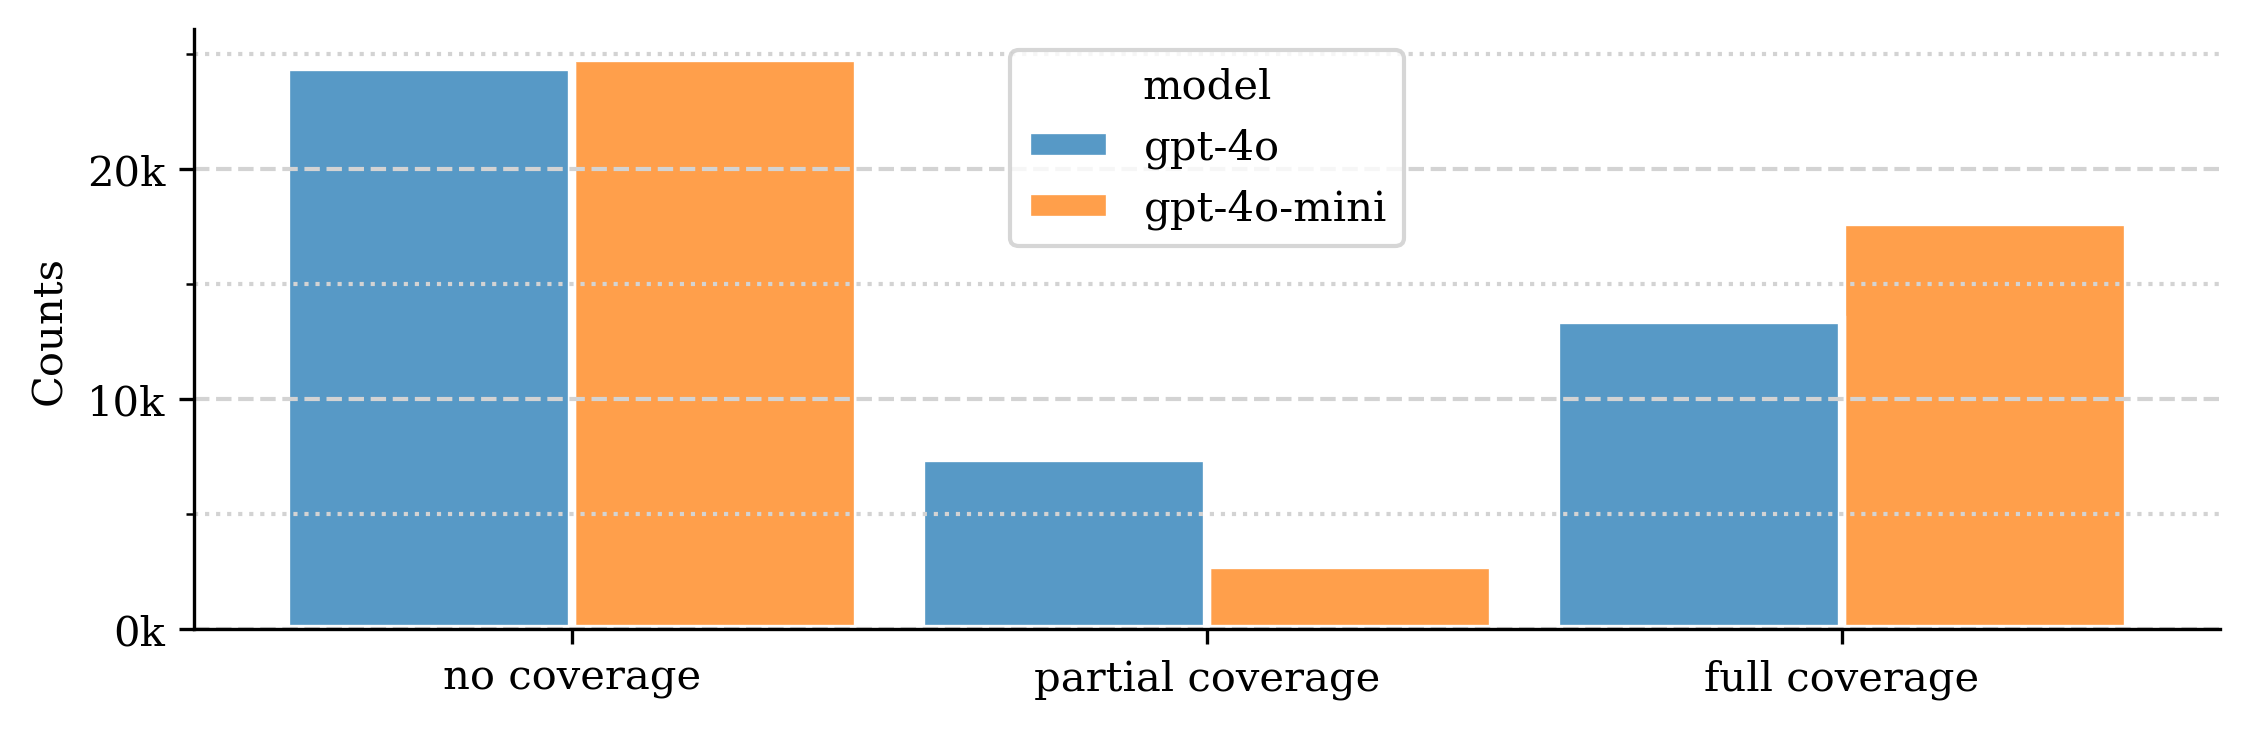

In [125]:
df_box = pd.concat((
    pd.DataFrame({
        "model": ["gpt-4o"] * len(results),
        "label": results["model1_label"].values.tolist(),
    }),
    pd.DataFrame({
    "model": ["gpt-4o-mini"] * len(results),
    "label": results["model2_label"].values.tolist(),
    })
))

canonic_label_name = {
    "FULL_COVERAGE": "full coverage",
    "PARTIAL_COVERAGE": "partial coverage",
    "NO_COVERAGE": "no coverage",
}

df_box["label_canonic"] = df_box["label"].apply(lambda x: canonic_label_name[x])
df_box['label_canonic'] = pd.Categorical(df_box['label_canonic'], ['no coverage','partial coverage','full coverage'])


fig, ax = plt.subplots(1, 1, figsize=(FULL_WIDTH, 2), dpi=300)
sns.histplot(df_box, x="label_canonic", hue="model", multiple="dodge", shrink=.9, ec='w', lw=2, ax=ax)
remove_axes(ax)

ax.set_xlabel(None)
ax.set_ylabel("Counts")

from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, FuncFormatter

# Define a formatter function to convert counts to millions
def millions_formatter(x, pos):
    return f'{int(x / 1_000)}k'
    
ax.yaxis.set_minor_locator(MultipleLocator(5_000))
ax.yaxis.set_major_locator(MultipleLocator(10_000))
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

adjust(fig)
save_fig(fig, name="histplot/label_distribution_by_evaluator.pdf")

In [60]:
results.is_same_pred_uuid.value_counts() # / len(results)

is_same_pred_uuid
True     43263
False     2049
Name: count, dtype: int64

In [61]:
# linking disagreements (table 1 append, automatic metric valid)
results_disagree_pred_insights = results[~results["is_same_pred_uuid"]]
print(len(results_disagree_pred_insights))
results_disagree_pred_insights.groupby(["model1_label",	"model2_label"]).count()[["response_idx"]] / len(results_disagree_pred_insights)

2049


response_idx
model1_label     model2_label                  
FULL_COVERAGE    FULL_COVERAGE         0.167887
                 PARTIAL_COVERAGE      0.000488
NO_COVERAGE      FULL_COVERAGE         0.026354
                 PARTIAL_COVERAGE      0.175207
PARTIAL_COVERAGE FULL_COVERAGE         0.163982
                 NO_COVERAGE           0.390434
                 PARTIAL_COVERAGE      0.075647

In [62]:
# linking agreements, label breakdown (table 2 append, automatic metric valid)
results_agree_pred_insights.groupby(["model1_label", "model2_label"]).count()[["is_same_pred_uuid"]] # // len(results_agree_pred_insights)

is_same_pred_uuid
model1_label     model2_label                       
FULL_COVERAGE    FULL_COVERAGE                 13084
                 PARTIAL_COVERAGE                 18
NO_COVERAGE      NO_COVERAGE                   24029
PARTIAL_COVERAGE FULL_COVERAGE                  3877
                 PARTIAL_COVERAGE               2255

## Dump file

In [81]:
def collect_examples_for_manual_annot(df):
    annots = defaultdict(list)

    for _, example in df.iterrows():
        r_idx = example["response_idx"]
        ref_uuid = example["ref_uuid"]
    
        # step 1. get reference insight
        data1 = read_json(example["model1_filepath"])
        data2 = read_json(example["model2_filepath"])
    
        assert data1["assignments"][r_idx]['all_insights_uuids'] == data2["assignments"][r_idx]['all_insights_uuids']
        ref_insight = data1["insights"][ref_uuid]
    
        annots["metric_type"].append("ref -> pred")
        annots["summarizer"].append(example["model"])
    
        annots["ref__uuid"].append(ref_uuid)
        annots["ref__insight"].append(ref_insight["insight"])
        annots["ref__insight__subtopic"].append(ref_insight["subtopic"])
    
    
        if example["model1_label"] != "NO_COVERAGE":
            ref_cvr1 = data1["evaluation_assignments"]["metric__bidirectional"]["ref_coverage"]
            ref_cvr1 = {(r["response_idx"], r["ref_uuid"]): (r["pred_uuid"], r["coverage"]) for r in ref_cvr1}
    
            pred_uuid, coverage_label = ref_cvr1[(r_idx, ref_uuid)]
            for bullet_ix, bullet in enumerate(data1["assignments"][r_idx]["response__parsed"]):
                if generate_uuid({"text": bullet}) == pred_uuid:
                    annots["pred__label__model1"].append(coverage_label)
                    annots["pred__uuid__model1"].append(pred_uuid)
                    annots["pred__insight__model1"].append(bullet)
                    annots["pred__position__model1"].append(bullet_ix)
                    break
            else:
                raise ValueError(f"Couldn't find pred_uuid: {pred_uuid} in {data1["assignments"][r_idx]["response__parsed"]}")
        else:
            annots["pred__label__model1"].append("NO_COVERAGE")
            annots["pred__uuid__model1"].append(None)
            annots["pred__insight__model1"].append(None)
            annots["pred__position__model1"].append(None)
    
        
        if example["model2_label"] != "NO_COVERAGE":
            ref_cvr2 = data2["evaluation_assignments"]["metric__bidirectional"]["ref_coverage"]
            ref_cvr2 = {(r["response_idx"], r["ref_uuid"]): (r["pred_uuid"], r["coverage"]) for r in ref_cvr2}
    
            pred_uuid, coverage_label = ref_cvr2[(r_idx, ref_uuid)]
            for bullet_ix, bullet in enumerate(data2["assignments"][r_idx]["response__parsed"]):
                if generate_uuid({"text": bullet}) == pred_uuid:
                    annots["pred__label__model2"].append(coverage_label)
                    annots["pred__uuid__model2"].append(pred_uuid)
                    annots["pred__insight__model2"].append(bullet)
                    annots["pred__position__model2"].append(bullet_ix)
                    break
            else:
                raise ValueError(f"Couldn't find pred_uuid: {pred_uuid} in {data1["assignments"][r_idx]["response__parsed"]}")
        else:
            annots["pred__label__model2"].append("NO_COVERAGE")
            annots["pred__uuid__model2"].append(None)
            annots["pred__insight__model2"].append(None)
            annots["pred__position__model2"].append(None)
    
        annots["predicted_bullet_points"].append("\n".join(data1["assignments"][r_idx]["response__parsed"]))
    
    annots = pd.DataFrame(annots)
    annots["model1"] = "gpt-4o-2024-05-13"
    annots["model2"] = "gpt-4o-mini-2024-07-18"
    return annots

In [83]:
## dump examples w/ linking disagreement but preds match
file1 = results_disagree_pred_insights[ results_disagree_pred_insights["model1_label"] == results_disagree_pred_insights["model2_label"]]
file1_annots = collect_examples_for_manual_annot(file1)
file1_annots = file1_annots.sample(n=len(file1_annots), replace=False, random_state=87123)
file1_annots.to_csv("./annotations/link_disagreement__1.csv", index=None)

In [84]:
## dump examples w/ linking disagreement but preds model1 > preds model2
model_label1_int = results_disagree_pred_insights["model1_label"].apply(lambda x: mappings[x])
model_label2_int = results_disagree_pred_insights["model2_label"].apply(lambda x: mappings[x])

file2 = results_disagree_pred_insights[model_label1_int < model_label2_int]
file2_annots = collect_examples_for_manual_annot(file2)
file2_annots = file2_annots.sample(n=len(file2_annots), replace=False, random_state=87123)
file2_annots.to_csv("./annotations/link_disagreement__2.csv", index=None)

In [82]:
## dump examples w/ linking disagreement but preds model2 < preds model1
model_label1_int = results_disagree_pred_insights["model1_label"].apply(lambda x: mappings[x])
model_label2_int = results_disagree_pred_insights["model2_label"].apply(lambda x: mappings[x])

file3 = results_disagree_pred_insights[model_label1_int > model_label2_int]
file3_annots = collect_examples_for_manual_annot(file3)
file3_annots = file3_annots.sample(n=len(file3_annots), replace=False, random_state=87123)
file3_annots.to_csv("./annotations/link_disagreement__3.csv", index=None)

## Analysis examples w/ same predicted insight

In [187]:
diff_pred_uuid = results[(results["model1_label"] == results["model2_label"]) & ~(results.is_same_pred_uuid)]
diff_pred_uuid

,response_idx,ref_uuid,pred_uuid_model1,pred_uuid_model2,model1_label,model2_label,is_same_pred_uuid,combination,prompt,model,model1_filepath,model2_filepath
130,46,b8QTk5e7M4vQlL8ZeB4OVgvc,4a0828a798bed4d114d6f8151e88917f,19083481d62c522708d55656dd62aa49,FULL_COVERAGE,FULL_COVERAGE,False,2,subtopic,gpt-4o-2024-05-13,../outputs/run_evals_postprocessing-multi-requ...,../outputs/run_evals_postprocessing-multi-requ...
131,68,b8QTk5e7M4vQlL8ZeB4OVgvc,02e3e7a9479c450342532d75b6f1aa87,a38f48ad6cd7409dbfc588f982255605,PARTIAL_COVERAGE,PARTIAL_COVERAGE,False,2,subtopic,gpt-4o-2024-05-13,../outputs/run_evals_postprocessing-multi-requ...,../outputs/run_evals_postprocessing-multi-requ...
245,33,b8QTk5e7M4vQlL8ZeB4OVgvc,3aca5512255dd3e27c4a6a9933474623,7368ff6b0b0df3df49d397394a1a5d43,FULL_COVERAGE,FULL_COVERAGE,False,2,subtopic,gpt-4o-2024-05-13,../outputs/run_evals_postprocessing-multi-requ...,../outputs/run_evals_postprocessing-multi-requ...
311,90,zxx1VD3nCkcGACX6dcwToF02,3ff03b4404b2f556ea4ce0916698e18e,a88921cef78fac444b13ff9c92901cd2,FULL_COVERAGE,FULL_COVERAGE,False,2,subtopic,gpt-4o-2024-05-13,../outputs/run_evals_postprocessing-multi-requ...,../outputs/run_evals_postprocessing-multi-requ...
313,14,dUk80VnKmRG1OuE3q1TfTwzB,a2b52c059de71efa5d61dfa6d3cbfff2,3d7b42763df1d8ed09196fca59e6272f,FULL_COVERAGE,FULL_COVERAGE,False,2,subtopic,gpt-4o-2024-05-13,../outputs/run_evals_postprocessing-multi-requ...,../outputs/run_evals_postprocessing-multi-requ...
...,...,...,...,...,...,...,...,...,...,...,...,...
440,22,pdSzQvcgU7JGFiw8vxb2D91P,4f3e80c6513be287e3dfe6fce4db9fcc,db85ee4c0378583e5245fe221038e644,FULL_COVERAGE,FULL_COVERAGE,False,2,subtopic_trustworthy,accounts/fireworks/models/qwen2-72b-instruct,../outputs/run_evals_postprocessing-multi-requ...,../outputs/run_evals_postprocessing-multi-requ...
516,73,a5tm4de9GCdp7GnpwQMToWPk,650e7b668aa41a7fc47b39691ad10ab8,f35cf05626ab7bea4938c8118d1a77d2,FULL_COVERAGE,FULL_COVERAGE,False,2,subtopic_trustworthy,accounts/fireworks/models/qwen2-72b-instruct,../outputs/run_evals_postprocessing-multi-requ...,../outputs/run_evals_postprocessing-multi-requ...
731,8,CqRpMCV2O5O9fyKacKqCs3Y5,049fbc83cc231447f4e1f0427df3e9a8,277572f349d826783cce38272d735239,FULL_COVERAGE,FULL_COVERAGE,False,2,subtopic_trustworthy,accounts/fireworks/models/qwen2-72b-instruct,../outputs/run_evals_postprocessing-multi-requ...,../outputs/run_evals_postprocessing-multi-requ...
1035,81,a5tm4de9GCdp7GnpwQMToWPk,941653a2f34d5cc5f4318e5a82c08c3a,ca1cb4cc08e29caff98ef75ff3174fad,FULL_COVERAGE,FULL_COVERAGE,False,2,subtopic_trustworthy,accounts/fireworks/models/qwen2-72b-instruct,../outputs/run_evals_postprocessing-multi-requ...,../outputs/run_evals_postprocessing-multi-requ...


In [188]:

annots.to_csv("./annotations/metrics_disagreement__diff_bullet_ix__same_label__annotations.csv", index=None)

In [90]:
disagreement = results[results["model1_label"] != results["model2_label"]]

(disagreement.groupby(["model2_label", "model1_label"]).count())[["response_idx"]].reset_index().rename(
    {
        #"model1_label": "gpt-4o-2024-05-1",
        #"model2_label": "gpt-4o-mini-2024-07-18",
        "response_idx": "counts"}, axis=1
)

,model2_label,model1_label,counts
0,FULL_COVERAGE,NO_COVERAGE,54
1,FULL_COVERAGE,PARTIAL_COVERAGE,4213
2,NO_COVERAGE,PARTIAL_COVERAGE,800
3,PARTIAL_COVERAGE,FULL_COVERAGE,19
4,PARTIAL_COVERAGE,NO_COVERAGE,359


disagreement_fract = (disagreement.groupby(["model2_label", "model1_label"]).count() / len(disagreement))[["response_idx"]].reset_index().rename({
    #"model1_label": "gpt-4o-2024-05-1",
    # "model2_label": "gpt-4o-mini-2024-07-18",
    "response_idx": "disagreement (%)"}, axis=1
)
disagreement_fract["disagreement (%)"] = np.round(disagreement_fract["disagreement (%)"] * 100, 2)
disagreement_fract

In [92]:
len(disagreement)

5445

## Example selection:

To better understand which model is better or not, we'll manually annotate a few examples. Since the majority of disagreement are cases where models predict **FC & PC** (4213), **NC and PC** (800), **PC and NC** (359). We will focus the annotation on those.

In [159]:
manual_examples_mask = (
    (disagreement["model1_label"] == "PARTIAL_COVERAGE") & (disagreement["model2_label"] == "FULL_COVERAGE")
    | (disagreement["model1_label"] == "PARTIAL_COVERAGE") & (disagreement["model2_label"] == "NO_COVERAGE")
    | (disagreement["model1_label"] == "NO_COVERAGE") & (disagreement["model2_label"] == "PARTIAL_COVERAGE")
)

manual_sel = disagreement[manual_examples_mask].sample(200, replace=False, random_state=71264)
manual_sel.groupby(["model2_label", "model1_label"]).count()

,,response_idx,ref_uuid,pred_uuid,combination,prompt,model,model1_filepath,model2_filepath
model2_label,model1_label,,,,,,,,
FULL_COVERAGE,PARTIAL_COVERAGE,150,150,150,150,150,150,150,150
NO_COVERAGE,PARTIAL_COVERAGE,31,31,31,31,31,31,31,31
PARTIAL_COVERAGE,NO_COVERAGE,19,19,19,19,19,19,19,19


In [169]:
manual_sel.head(25).model.value_counts()

model
accounts/fireworks/models/qwen2-72b-instruct         11
gpt-4o-2024-05-13                                     6
gpt-3.5-turbo-0125                                    5
accounts/fireworks/models/llama-v3p1-70b-instruct     3
Name: count, dtype: int64

In [165]:
annots = defaultdict(list)

for _, example in manual_sel.iterrows():
    r_idx = example["response_idx"]
    ref_uuid = example["ref_uuid"]

    # step 1. get reference insight
    data1 = read_json(example["model1_filepath"])
    data2 = read_json(example["model2_filepath"])

    assert data1["assignments"][r_idx]['all_insights_uuids'] == data2["assignments"][r_idx]['all_insights_uuids']
    ref_insight = data1["insights"][ref_uuid]

    annots["metric_type"].append("ref -> pred")
    annots["summarizer"].append(example["model"])

    annots["ref__uuid"].append(ref_uuid)
    annots["ref__insight"].append(ref_insight["insight"])
    annots["ref__insight__subtopic"].append(ref_insight["subtopic"])


    if example["model1_label"] != "NO_COVERAGE":
        ref_cvr1 = data1["evaluation_assignments"]["metric__bidirectional"]["ref_coverage"]
        ref_cvr1 = {(r["response_idx"], r["ref_uuid"]): (r["pred_uuid"], r["coverage"]) for r in ref_cvr1}

        pred_uuid, coverage_label = ref_cvr1[(r_idx, ref_uuid)]

        for bullet_ix, bullet in enumerate(data1["assignments"][r_idx]["response__parsed"]):
            if generate_uuid({"text": bullet}) == pred_uuid:
                annots["pred__label__model1"].append(coverage_label)
                annots["pred__uuid__model1"].append(pred_uuid)
                annots["pred__insight__model1"].append(bullet)
                annots["pred__position__model1"].append(bullet_ix)
                break
        else:
            raise ValueError(f"Couldn't find pred_uuid: {pred_uuid} in {data1["assignments"][r_idx]["response__parsed"]}")
    else:
        annots["pred__label__model1"].append("NO_COVERAGE")
        annots["pred__uuid__model1"].append(None)
        annots["pred__insight__model1"].append(None)
        annots["pred__position__model1"].append(None)

    
    if example["model2_label"] != "NO_COVERAGE":
        ref_cvr2 = data2["evaluation_assignments"]["metric__bidirectional"]["ref_coverage"]
        ref_cvr2 = {(r["response_idx"], r["ref_uuid"]): (r["pred_uuid"], r["coverage"]) for r in ref_cvr2}

        pred_uuid, coverage_label = ref_cvr2[(r_idx, ref_uuid)]

        for bullet_ix, bullet in enumerate(data2["assignments"][r_idx]["response__parsed"]):
            if generate_uuid({"text": bullet}) == pred_uuid:
                annots["pred__label__model2"].append(coverage_label)
                annots["pred__uuid__model2"].append(pred_uuid)
                annots["pred__insight__model2"].append(bullet)
                annots["pred__position__model2"].append(bullet_ix)
                break
        else:
            raise ValueError(f"Couldn't find pred_uuid: {pred_uuid} in {data1["assignments"][r_idx]["response__parsed"]}")
    else:
        annots["pred__label__model2"].append("NO_COVERAGE")
        annots["pred__uuid__model2"].append(None)
        annots["pred__insight__model2"].append(None)
        annots["pred__position__model2"].append(None)

    annots["predicted_bullet_points"].append(data1["assignments"][r_idx]["response__parsed"])

annots = pd.DataFrame(annots)
annots["model1"] = "gpt-4o-2024-05-13"
annots["model2"] = "gpt-4o-mini-2024-07-18"
annots.to_csv("./annotations/metrics_disagreement_annotations.csv", index=None)

In [164]:
annots.to_csv("./annotations/metrics_disagreement_annotations.csv", index=None)